In [1]:
import pandas as pd

files = ['/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/data_dictionary.csv',
         '/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/sample.csv',
         '/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/test.csv',
         '/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/train.csv']


for file in files:
    if 'data_dictionary' in file.lower():
        data_dict_df = pd.read_csv(file)
        print(f'Data Dictionary:\n{data_dict_df}')
    else:
        df = pd.read_csv(file)
        print(f'Loaded {file}')
        print(df.head())
        print(df.describe())
        print(f'Missing Values:\n{df.isnull().sum()}')
        print(f'Data Types:\n{df.dtypes}')
        print('\n')
        
    

Data Dictionary:
       Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the

### 1. Loading Dependencies and Datasets

In [2]:
# Data Structures
import pandas as pd
import numpy as np
import re
import os
import missingno as msno

#sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train_data = pd.read_csv('/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/train.csv')
test_data = pd.read_csv('/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/test.csv')
sample = pd.read_csv('/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/sample.csv')
data_dict = pd.read_csv('/Users/pavanramrathod/Downloads/Data_Sets/Telecom Competition/telecom-churn-case-study-hackathon-c55/data_dictionary.csv')

print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")
print(f"Sample Data Shape: {sample.shape}")
print(f"Data Dictionary Shape: {data_dict.shape}")

Training Data Shape: (69999, 172)
Test Data Shape: (30000, 171)
Sample Data Shape: (30000, 2)
Data Dictionary Shape: (36, 2)


In [4]:
print(data_dict)

       Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator ne

In [5]:
# Grouping Columns Based On Patterns
ids = ['id', 'circle_id']
total_amounts = [i for i in list(train_data.columns) if re.search('total.+amt', i)]
total_outgoing_minutes = [i for i in list(train_data.columns) if re.search('total.+og.+mou', i)]
offnetwork_minutes = [i for i in list(train_data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(train_data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(train_data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(train_data.columns) if re.search('vol.+3g', i)]
volume_2g = [i for i in list(train_data.columns) if re.search('vol.+2g', i)]
age_on_network = [i for i in list(train_data.columns) if re.search('aon', i)]

# Combining all variable lists
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g, 
             *volume_2g,
             *age_on_network,
             'churn_probability']

# Selecting columns and setting 'id' as index
data = train_data[variables].set_index('id')

In [6]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


In [7]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

In [8]:
# For the statistical summary....
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


### 2. Create X,y and the Train Test Split

In [9]:
# Checking unique values in 'circle_id'
unique_circle_ids = data['circle_id'].unique()
print("Unique Circle IDs:", unique_circle_ids)

Unique Circle IDs: [109]


In [10]:
# Creating feature matrix X and target variable y
X = data.drop(['circle_id'], axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

# Displaying shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (69999, 22)
Shape of y: (69999,)


In [11]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Displaying shapes of training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Displaying the head of the training set
X_train.head()

Shape of X_train: (55999, 22)
Shape of X_test: (14000, 22)
Shape of y_train: (55999,)
Shape of y_test: (14000,)


,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
65021,218,256,186,125.79,400.79,250.53,107.28,373.88,237.93,0.0,...,4.4,NaN,NaN,0.00,0.00,0.0,209.82,0.00,0.0,229
60981,100,140,170,111.34,111.96,151.28,85.59,94.98,132.03,NaN,...,NaN,NaN,NaN,0.00,0.00,0.0,0.00,0.00,0.0,1756
38221,558,507,279,525.81,351.33,442.24,236.33,203.11,237.74,0.0,...,0.0,0.0,NaN,667.88,1171.79,0.0,50.64,34.85,0.0,3651
10146,740,522,470,717.36,418.66,554.33,311.83,144.63,146.36,NaN,...,NaN,0.0,NaN,0.00,0.00,0.0,0.00,0.00,0.0,683
41837,666,876,1046,1019.53,1617.26,2288.24,258.88,108.11,143.73,NaN,...,NaN,NaN,NaN,0.00,0.00,0.0,0.00,0.00,0.0,242


### Handling Missing Data

<Axes: >

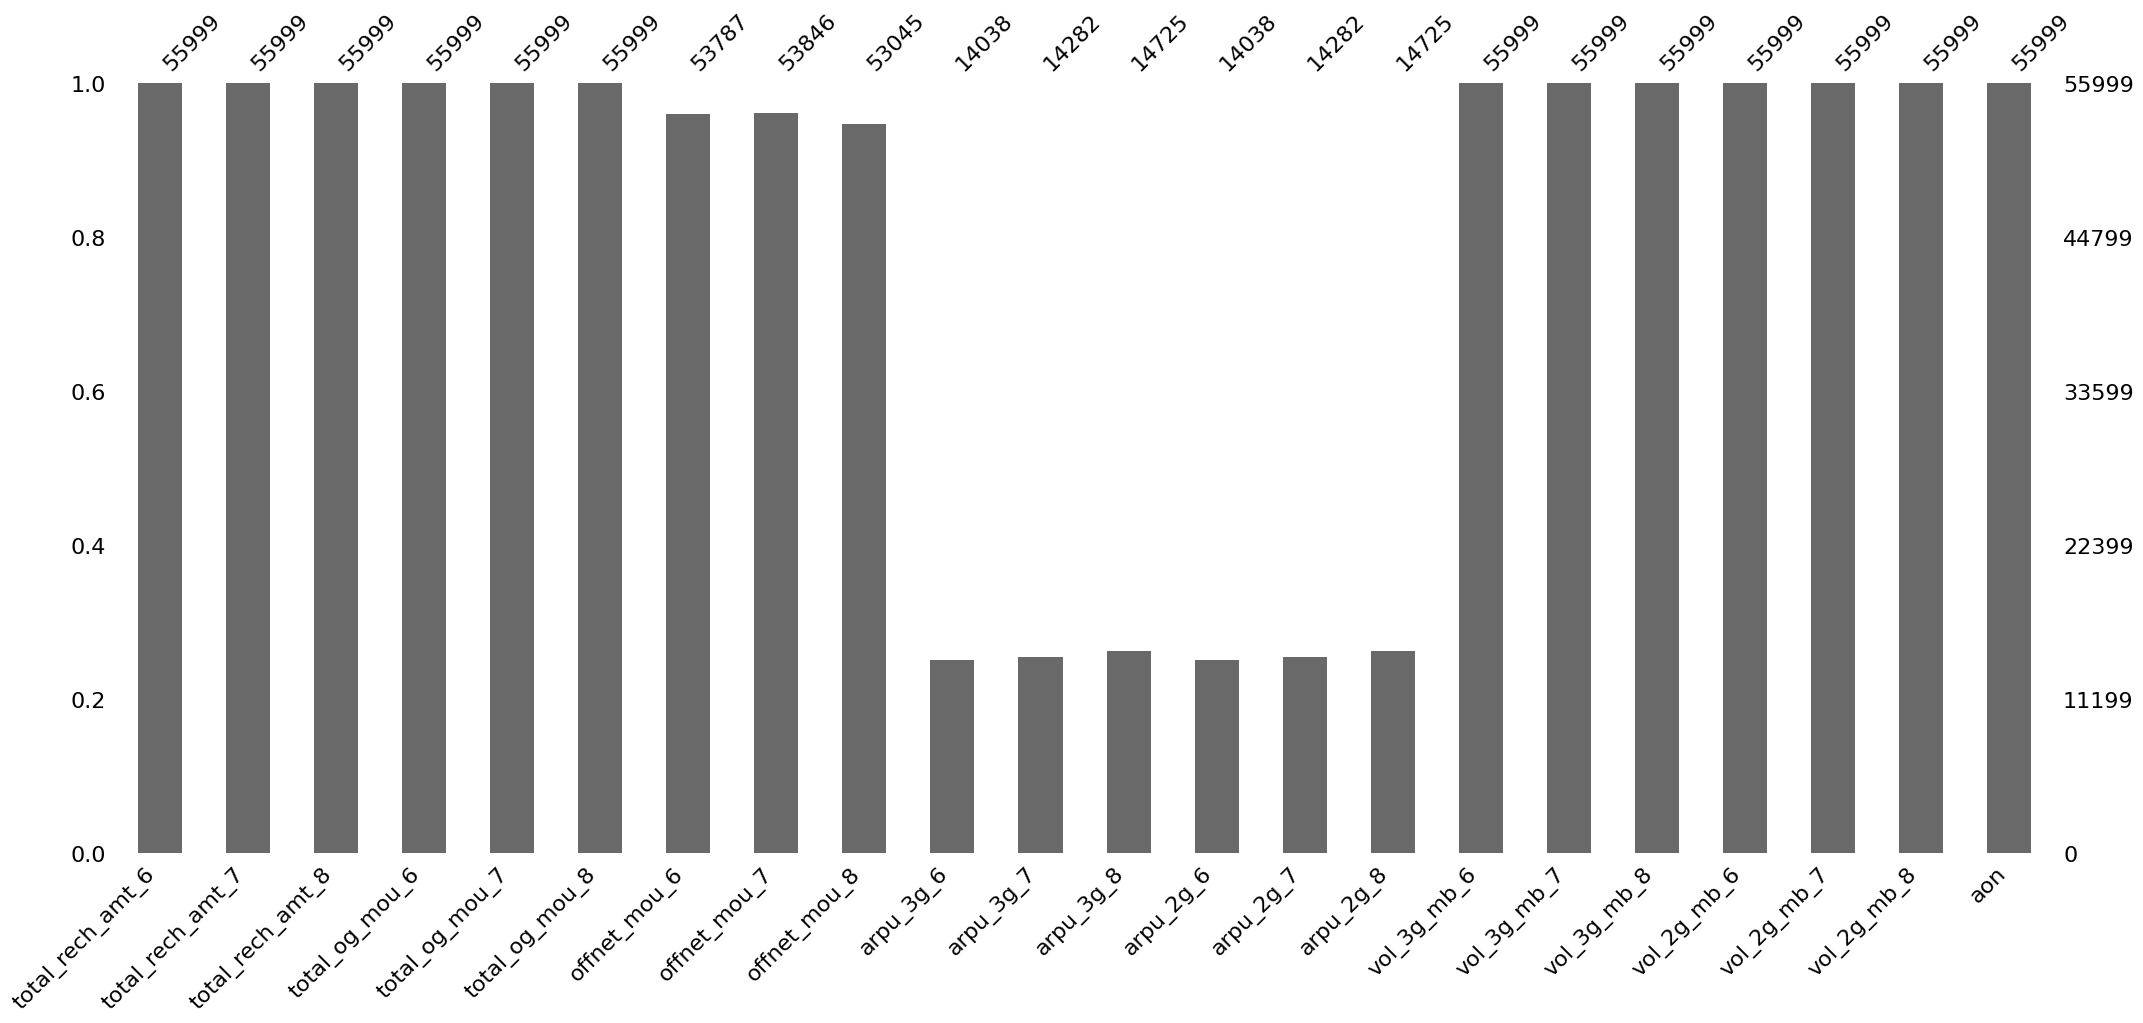

In [12]:
# Visualizing missing data in the training set
msno.bar(X_train)

<Axes: >

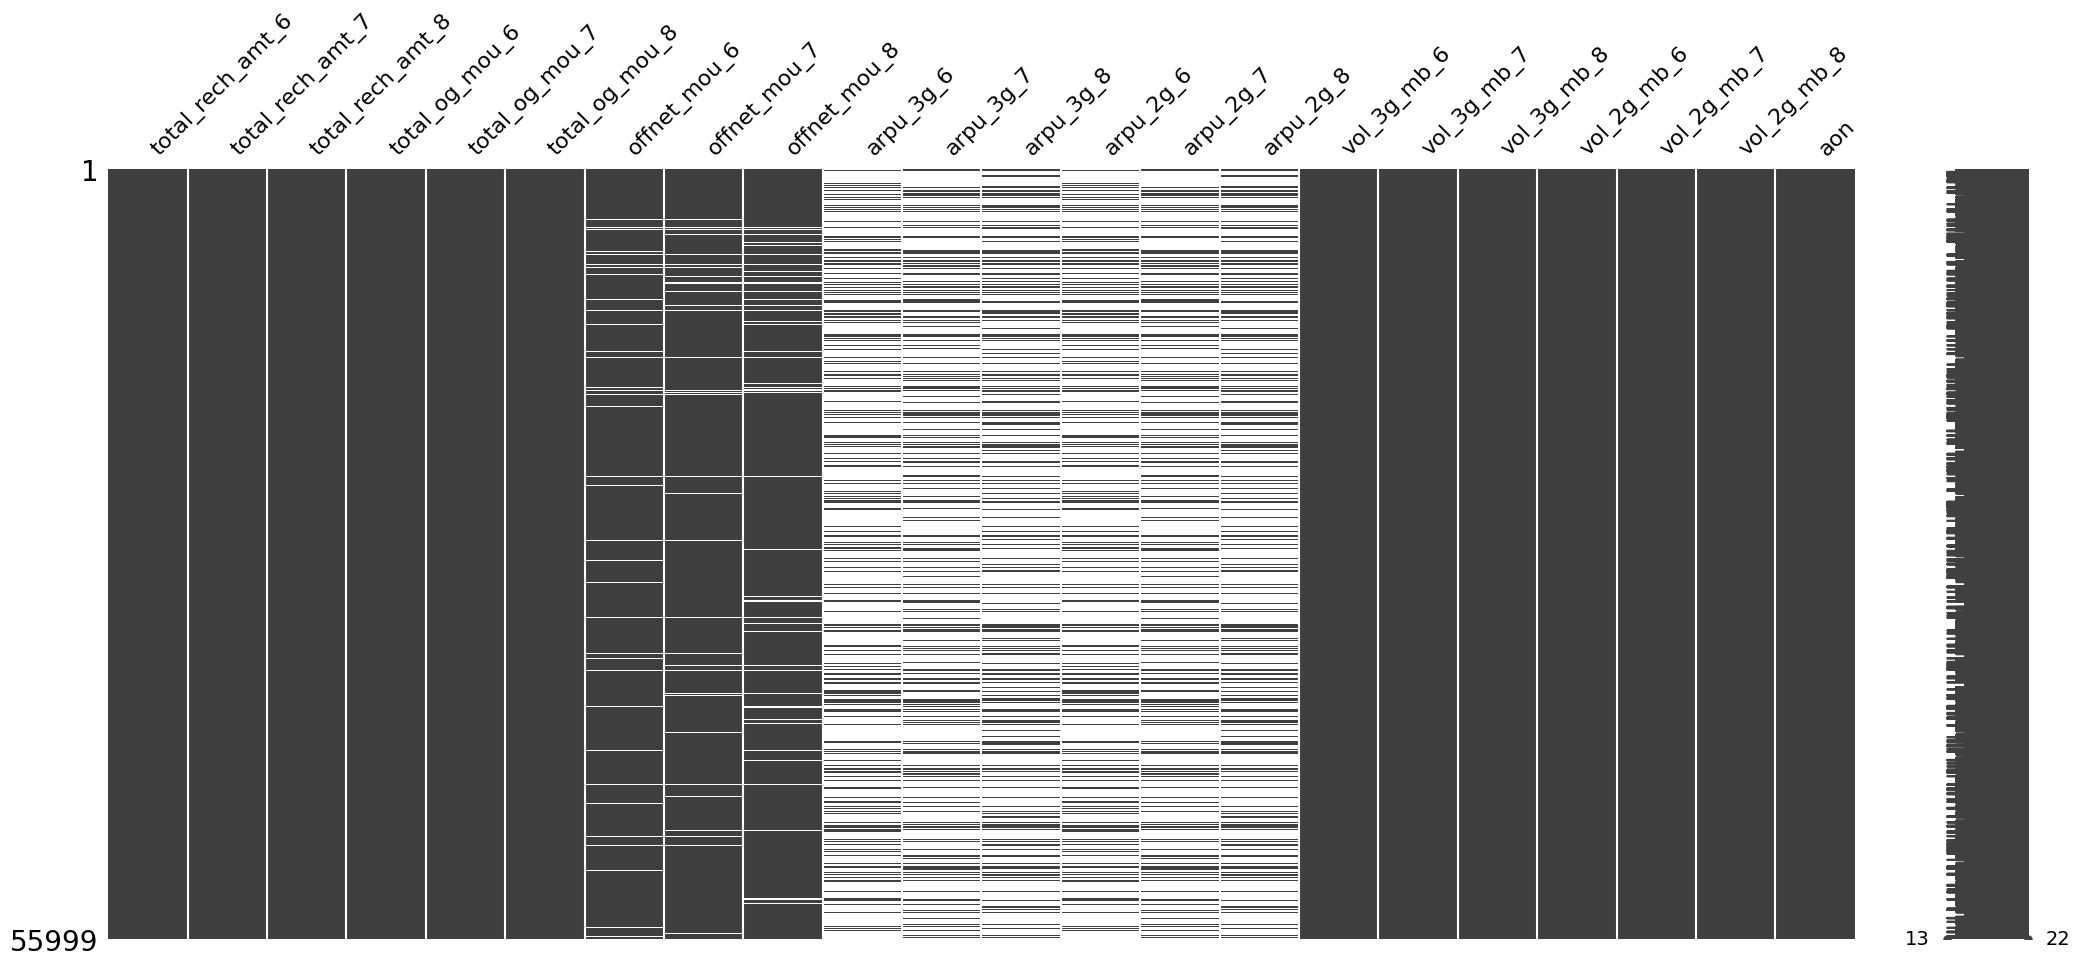

In [13]:
# Visualizing the distribution of missing data in the training set
msno.matrix(X_train)

In [14]:
# Calculating the percentage of missing data for each column
missing_data_percent = 100 * X_train.isnull().sum() / len(y_train)

# Displaying the percentage of missing data for each column
missing_data_percent

total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.950071
offnet_mou_7         3.844712
offnet_mou_8         5.275094
arpu_3g_6           74.931695
arpu_3g_7           74.495973
arpu_3g_8           73.704888
arpu_2g_6           74.931695
arpu_2g_7           74.495973
arpu_2g_8           73.704888
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
dtype: float64

In [15]:
# Selecting columns with less than or equal to 40% missing data
new_vars = missing_data_percent[missing_data_percent.le(40)].index

# Displaying the selected columns
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [16]:
# Selecting only the columns with less than or equal to 40% missing data in the training set
X_train_filtered = X_train[new_vars]

# Displaying the shape of the filtered training set
X_train_filtered.shape

(55999, 16)

In [17]:
# Checking if there are any missing values in each column
missing_data_percent = X_train_filtered.isnull().any()

# Selecting columns that have missing values
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index

# Displaying the columns that need imputation
impute_cols


Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [18]:
# Creating a SimpleImputer object with strategy 'constant' and fill_value 0
imp = SimpleImputer(strategy='constant', fill_value=0)

# Filling missing values in the specified columns with the constant value 0
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])


<Axes: >

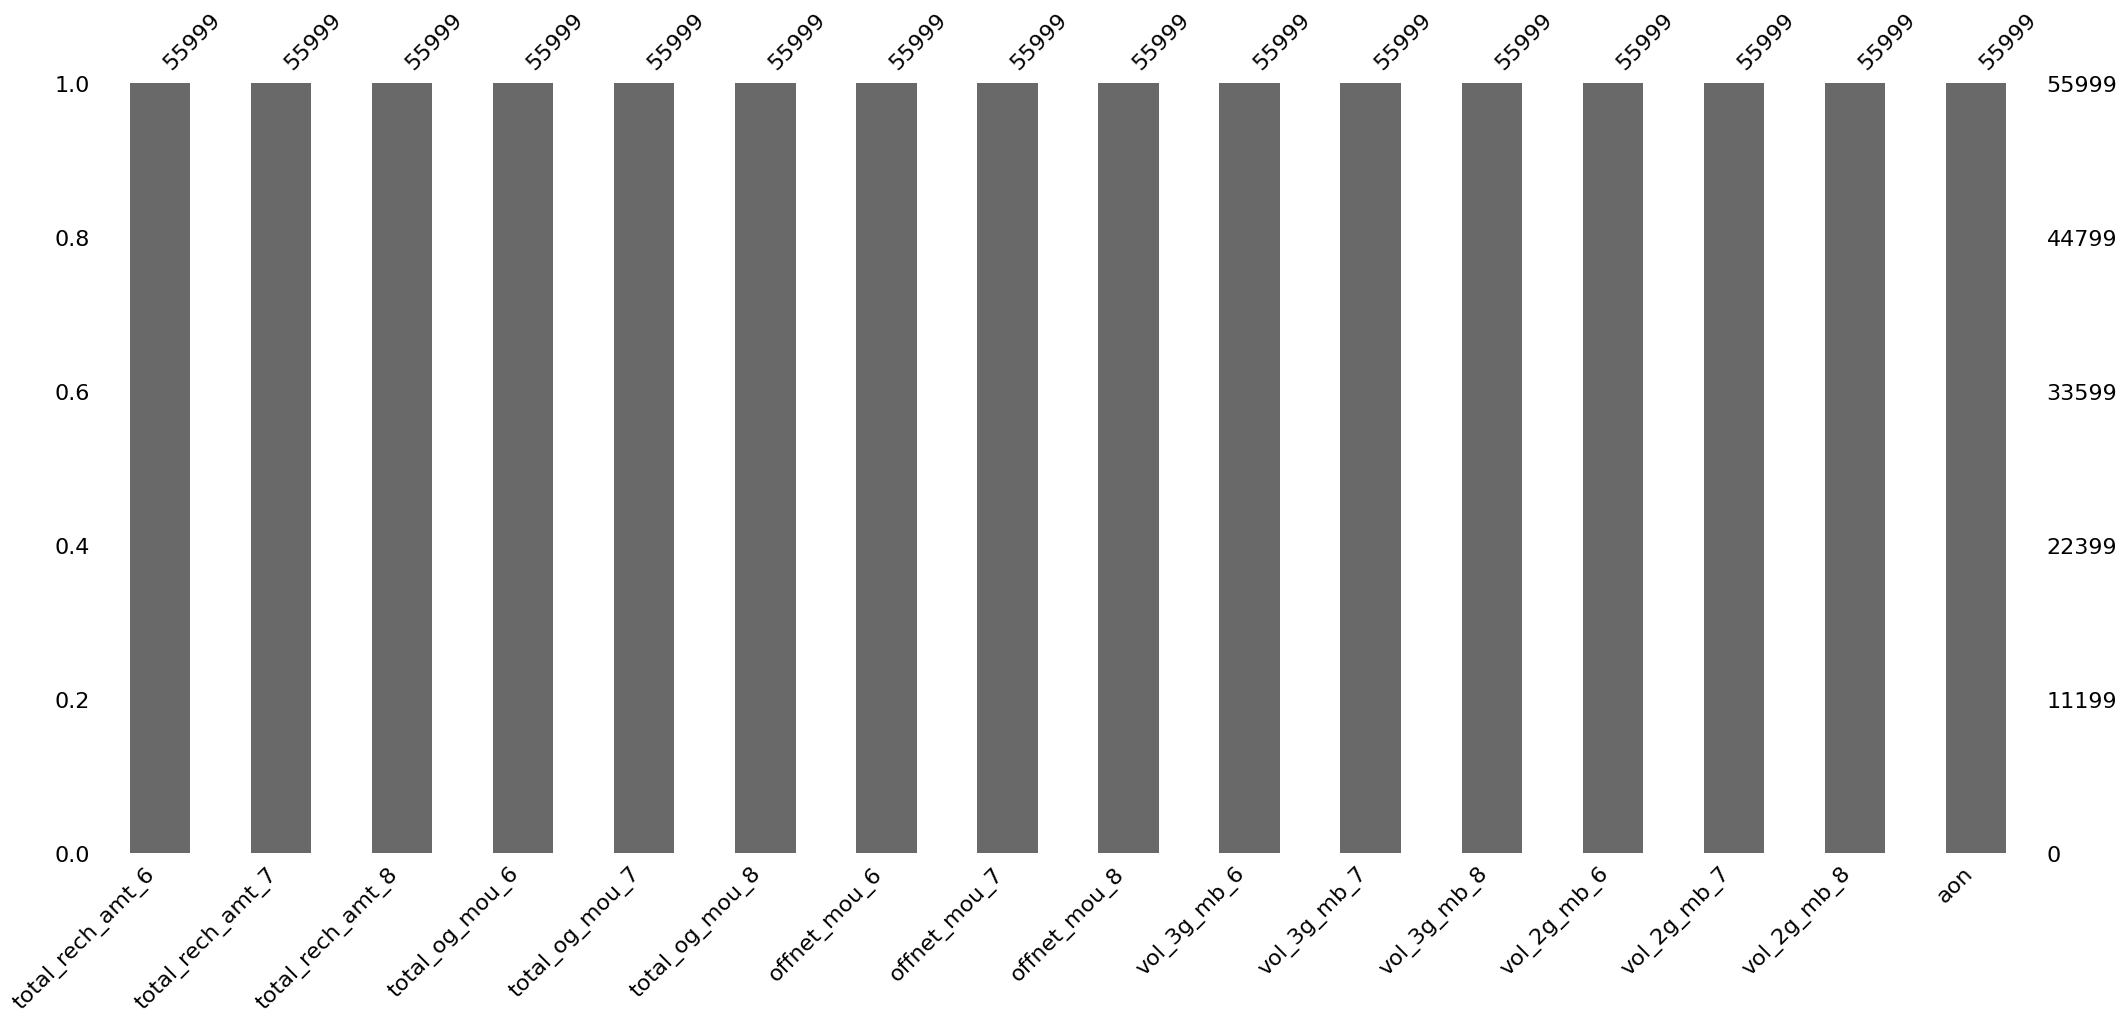

In [19]:
# Visualizing missing data in the filtered training set after imputation
msno.bar(X_train_filtered)

In [20]:
# Displaying descriptive statistics for the filtered training set
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,328.366024,323.039965,326.093984,305.953989,310.804756,306.126734,190.527707,189.642924,187.339646,121.890100,129.229311,136.567771,51.147707,50.500116,49.572788,1222.594743
std,415.843208,422.404042,443.323990,464.321387,481.165965,482.482106,310.249893,318.978204,322.811918,554.627461,563.345726,579.251589,211.182852,210.808318,213.412835,953.842434
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,110.000000,100.000000,90.000000,44.750000,43.320000,39.310000,28.870000,26.980000,24.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000
50%,229.000000,220.000000,226.000000,144.940000,141.430000,138.490000,89.840000,85.860000,83.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,871.000000
75%,437.000000,430.000000,437.000000,372.835000,379.635000,371.985000,223.580000,218.800000,217.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1815.000000
max,35190.000000,40335.000000,45320.000000,7597.180000,8285.640000,14043.060000,6712.810000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000


### 4. Exploratory Data Analysis & Preprocessing.

<Axes: >

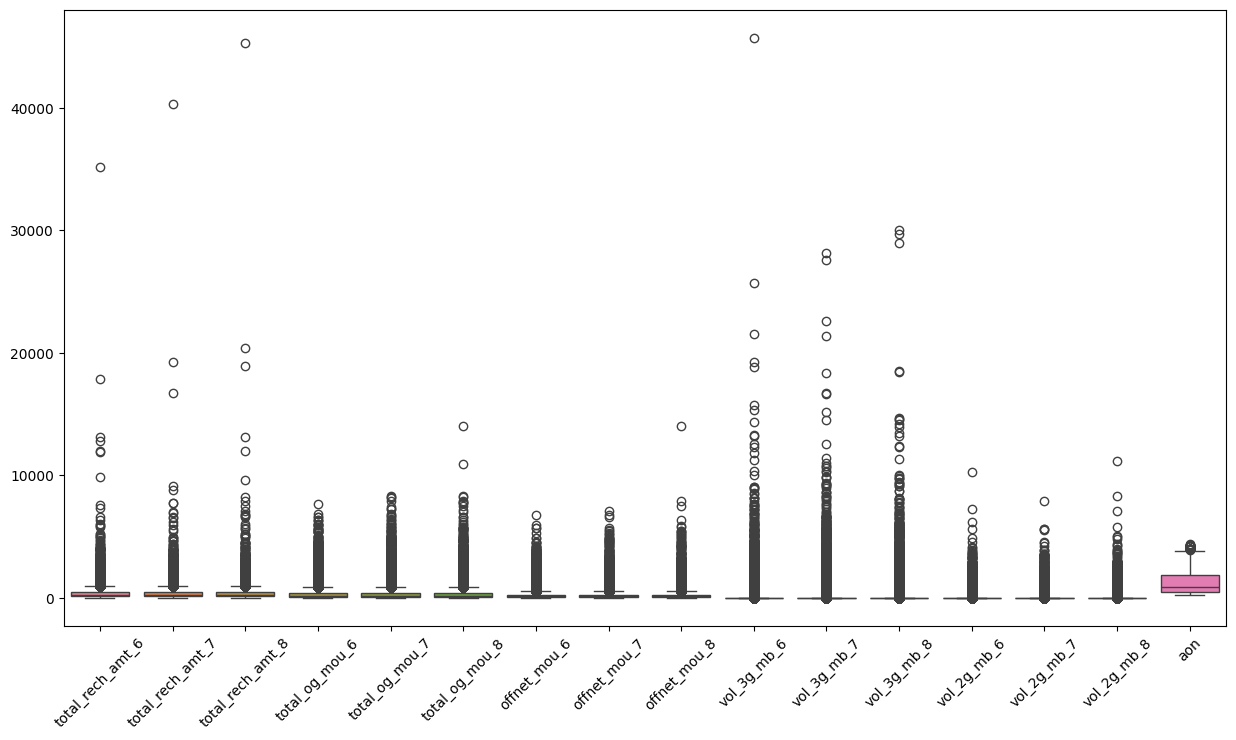

In [21]:
# Setting the size of the figure
plt.figure(figsize=(15,8))

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Creating a boxplot using seaborn
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

In [22]:
def cap_outliers(array, k=3):
    # Calculate the upper and lower limits based on mean and standard deviation
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()

    # Cap values below the lower limit to the lower limit
    array[array<lower_limit] = lower_limit

    # Cap values above the upper limit to the upper limit
    array[array>upper_limit] = upper_limit

    # Return the capped array
    return array

<Axes: >

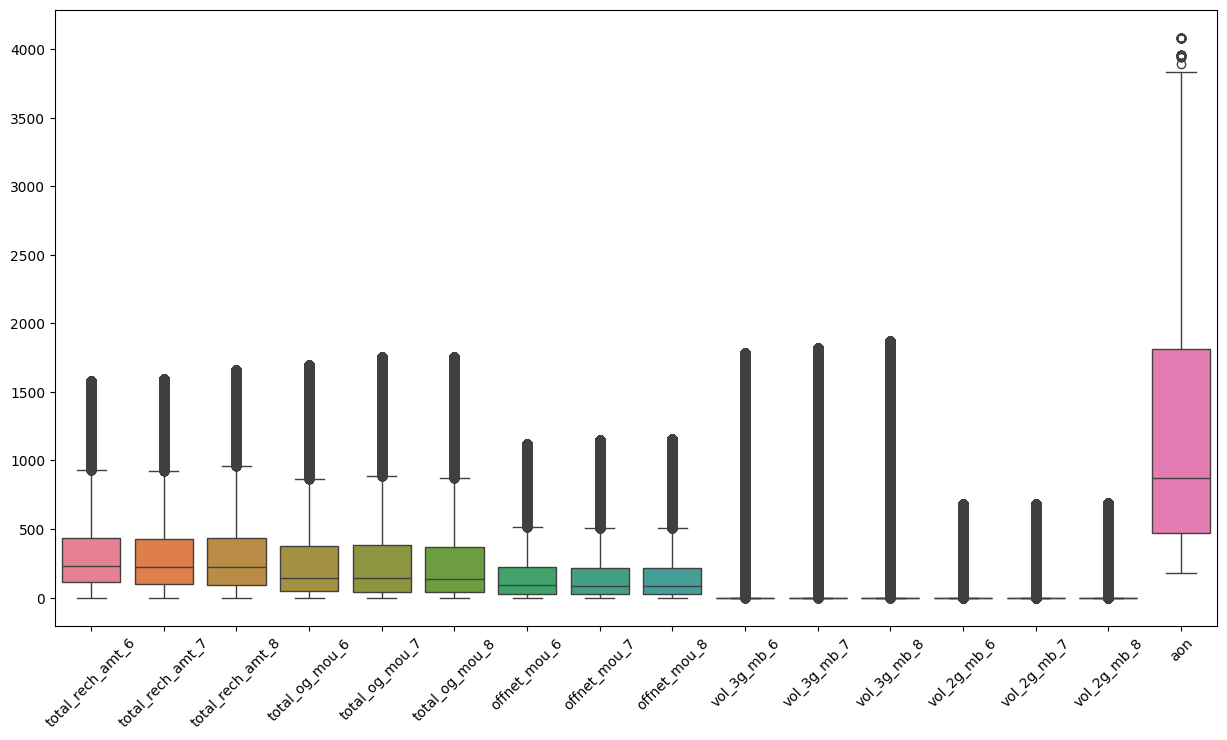

In [23]:
# Applying the cap_outliers function to each column in X_train_filtered
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

# Setting the size of the figure
plt.figure(figsize=(15,8))

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Creating a boxplot using seaborn for the capped data
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature Scaling

In [24]:
# Creating a StandardScaler object
scale = StandardScaler()

# Scaling the features in X_train_filtered1
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

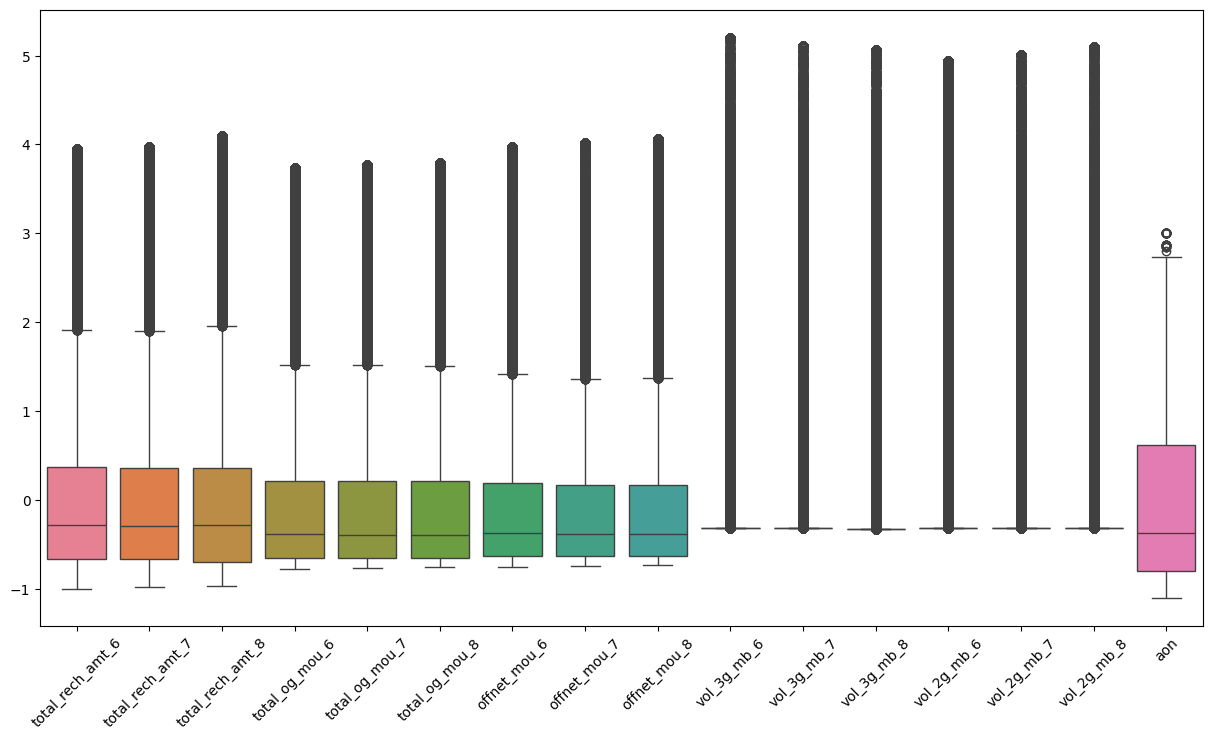

In [25]:
# Creating a figure with a specified size
plt.figure(figsize=(15, 8))

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Creating a boxplot using seaborn for the standardized features
sns.boxplot(data=pd.DataFrame(X_train_filtered2, columns=new_vars))


<Axes: >

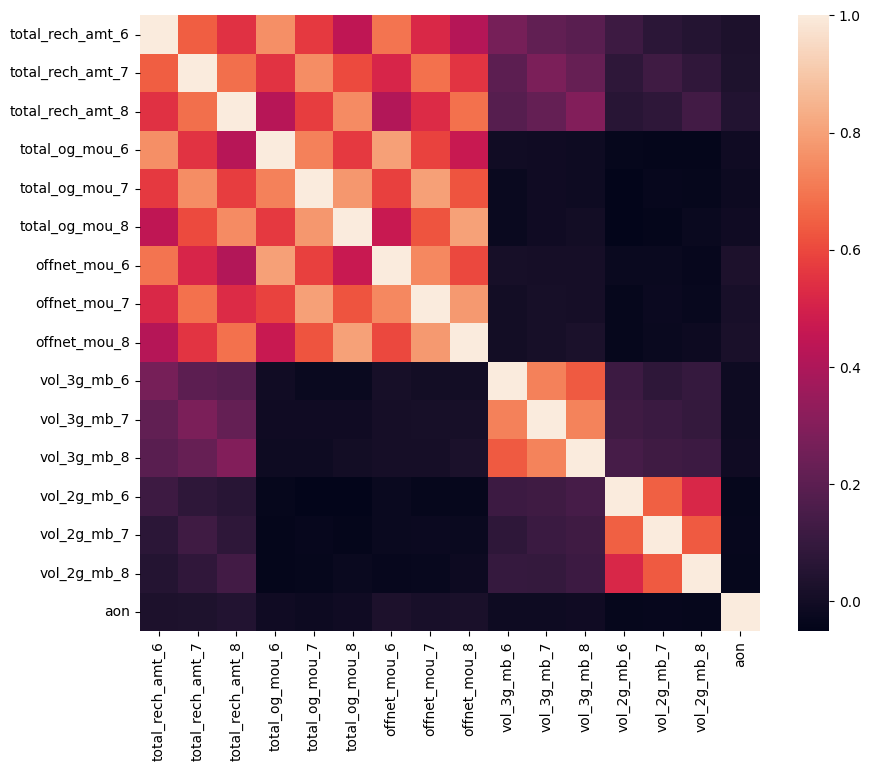

In [26]:
# Creating a figure with a specified size
plt.figure(figsize=(10, 8))

# Creating a heatmap of the correlation matrix using seaborn
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

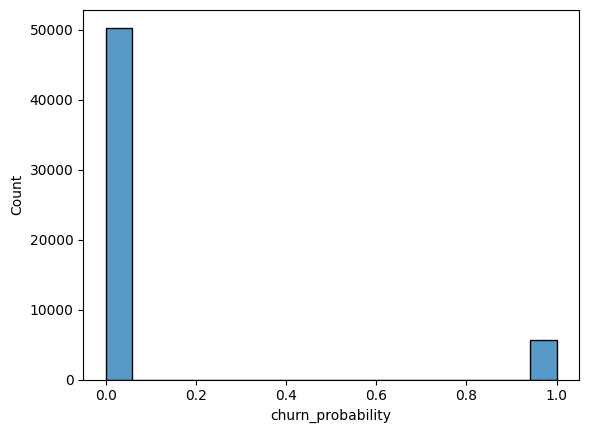

In [27]:
#Distribution for the churn probability
sns.histplot(y_train)

### 5. Feature Engineering and Selection

In [28]:
# Creating a Random Forest classifier with 100 trees and using all available CPU cores for parallel processing
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Fitting the Random Forest classifier to the training data
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [29]:
# Creating a DataFrame with feature names and their importances from the Random Forest classifier
feature_importances = pd.DataFrame({'col': new_vars, 'importance': rf.feature_importances_})

<BarContainer object of 16 artists>

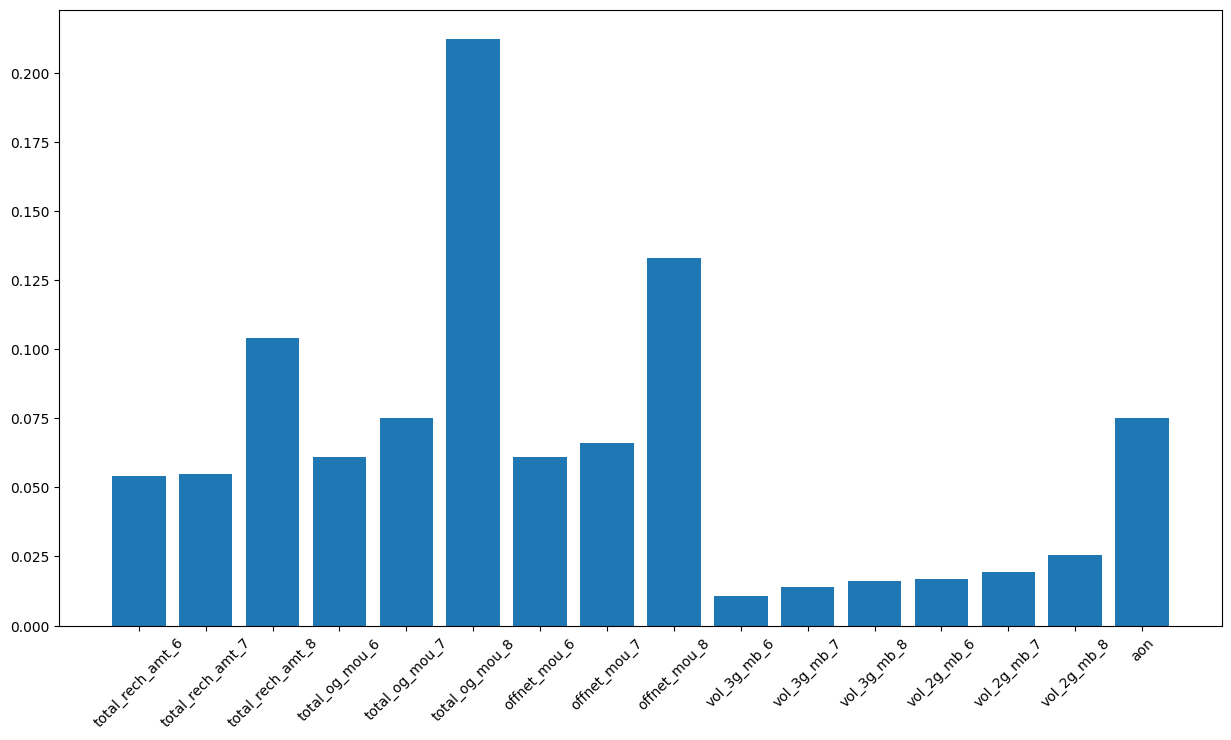

In [30]:
# Creating a figure with a specified size
plt.figure(figsize=(15, 8))

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Creating a bar chart using matplotlib to display feature importances
plt.bar(feature_importances['col'], feature_importances['importance'])

<Axes: >

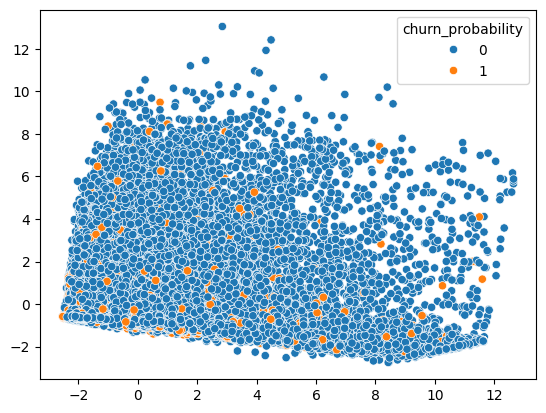

In [31]:
# Creating a PCA object
pca = PCA()

# Transforming the standardized features using PCA
pca_components = pca.fit_transform(X_train_filtered2)

# Creating a scatter plot using seaborn
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=y_train)

<Axes: >

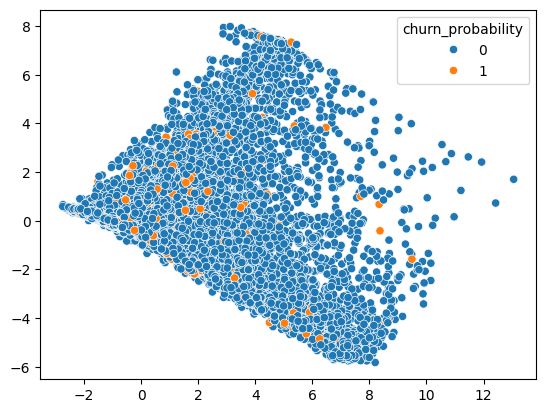

In [32]:
# Creating a scatter plot using seaborn
sns.scatterplot(x=pca_components[:, 1], y=pca_components[:, 2], hue=y_train)

<BarContainer object of 16 artists>

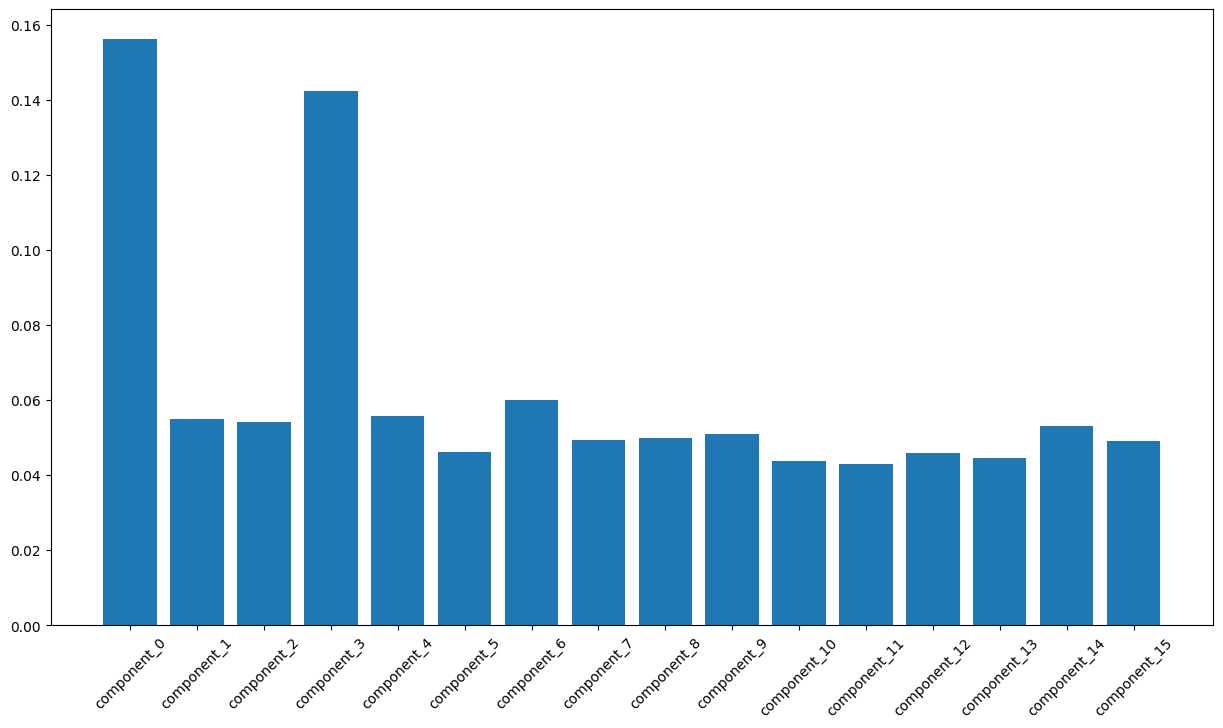

In [33]:
# Creating a Random Forest classifier with 100 trees and using all available CPU cores for parallel processing
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Fitting the Random Forest classifier to the principal components
rf.fit(pca_components, y_train)

# Creating a DataFrame with component names and their importances from the Random Forest classifier
feature_importances = pd.DataFrame({'col': ['component_' + str(i) for i in range(16)], 
                                    'importance': rf.feature_importances_})

# Creating a figure with a specified size
plt.figure(figsize=(15, 8))

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Creating a bar chart using matplotlib to display feature importances
plt.bar(feature_importances['col'], feature_importances['importance'])

### 6. Model Building

In [34]:
# Creating a Logistic Regression model with specific parameters
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')

# Fitting the Logistic Regression model to the first two principal components
lr.fit(pca_components[:, :2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [35]:
# Calculating the accuracy score of the logistic regression model on the first two principal components
accuracy_score = lr.score(pca_components[:, :2], y_train)

In [36]:
# Initializing a SimpleImputer with constant fill value 0
imp = SimpleImputer(strategy='constant', fill_value=0)

# Initializing a StandardScaler
scale = StandardScaler()

# Initializing a PCA (Principal Component Analysis) transformer with 10 components
pca = PCA(n_components=10)

# Initializing a Logistic Regression model with specific parameters
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [37]:
# Creating a scikit-learn pipeline with specified steps
pipe = Pipeline(steps=[
    ('imputation', imp),   # Imputation step using the SimpleImputer
    ('scaling', scale),     # Scaling step using the StandardScaler
    ('pca', pca),           # Dimensionality reduction step using PCA
    ('model', lr)           # Modeling step using Logistic Regression
])


In [38]:
# Fitting the pipeline on the training data
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [39]:
Pipeline(steps=[
    ('imputation', SimpleImputer(fill_value=0, strategy='constant')),
    ('scaling', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('model', LogisticRegression(max_iter=1000, tol=0.001))
])

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [40]:
# Calculating the training accuracy using the pipeline
train_score = pipe.score(X_train[new_vars], y_train)

# Printing the training accuracy
print("Training accuracy:", train_score)

Training accuracy: 0.9005696530295184


In [41]:
# Calculating the test accuracy using the pipeline
test_score = pipe.score(X_test[new_vars], y_test)

# Printing the test accuracy
print("Test accuracy:", test_score)

Test accuracy: 0.8987142857142857


In [42]:
# Calculating the confusion matrix on the training data
conf_matrix_train = confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

# Displaying the confusion matrix
print(conf_matrix_train)

[[50028   277]
 [ 5291   403]]


In [43]:
# Calculating the confusion matrix on the test data
conf_matrix_test = confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

# Displaying the confusion matrix
print(conf_matrix_test)

[[12483    79]
 [ 1339    99]]


In [44]:
# Calculating precision score on the test data
precision_test = precision_score(y_test, pipe.predict(X_test[new_vars]))

# Displaying the precision score
print("Precision Score on Test Data:", precision_test)

Precision Score on Test Data: 0.5561797752808989


In [45]:
# Calculating recall score on the test data
recall_test = recall_score(y_test, pipe.predict(X_test[new_vars]))

# Displaying the recall score
print("Recall Score on Test Data:", recall_test)

Recall Score on Test Data: 0.06884561891515995


### 7. Creating Submission File

In [46]:
train_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [48]:
test_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [49]:
submission_data = train_data.set_index('id')[new_vars]
submission_data.shape

(69999, 16)

In [50]:
train_data['churn_probability'] = pipe.predict(submission_data)
output = train_data[['id','churn_probability']]
output.head()

,id,churn_probability
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
